Right now all images are in one folder with `yes` and `no` subfolders. I will split the data into `train`, `val` and `test` folders which makes its easier to work for me. The new folder heirarchy will look as follows:

In [3]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from IPython.display import clear_output

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [4]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

The syntax of the command is incorrect.


Folder PATH listing for volume OS
Volume serial number is 40E2-95A2
C:\USERS\MOHAMMED HANY\ONEDRIVE\DESKTOP\DEPI\PROJECT\BACKEND\ROSHDA\MODELS\-D
Invalid path - \USERS\MOHAMMED HANY\ONEDRIVE\DESKTOP\DEPI\PROJECT\BACKEND\ROSHDA\MODELS\-D
No subfolders exist 



In [5]:
import random
import shutil
IMG_PATH = "brain_tumor_dataset"   # NO leading slash

# Output folders
OUTPUT_DIRS = ["TRAIN", "VAL", "TEST"]

for d in OUTPUT_DIRS:
    os.makedirs(d, exist_ok=True)

# Create class subfolders inside TRAIN/VAL/TEST
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        for d in OUTPUT_DIRS:
            os.makedirs(os.path.join(d, CLASS.upper()), exist_ok=True)

# ----------------------------------------------------
# SPLIT RATIOS
# ----------------------------------------------------
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1

# ----------------------------------------------------
# PROCESS EACH CLASS
# ----------------------------------------------------
for CLASS in os.listdir(IMG_PATH):
    if CLASS.startswith('.'):
        continue

    class_path = os.path.join(IMG_PATH, CLASS)
    files = [f for f in os.listdir(class_path) if not f.startswith('.')]
    
    random.shuffle(files)
    total = len(files)

    # Split indices
    train_end = int(TRAIN_SPLIT * total)
    val_end = train_end + int(VAL_SPLIT * total)

    train_files = files[:train_end]
    val_files = files[train_end:val_end]
    test_files = files[val_end:]

    # Copy files
    for fname in train_files:
        shutil.copy(
            os.path.join(class_path, fname),
            os.path.join("TRAIN", CLASS.upper(), fname)
        )

    for fname in val_files:
        shutil.copy(
            os.path.join(class_path, fname),
            os.path.join("VAL", CLASS.upper(), fname)
        )

    for fname in test_files:
        shutil.copy(
            os.path.join(class_path, fname),
            os.path.join("TEST", CLASS.upper(), fname)
        )

print("Dataset successfully split into TRAIN / VAL / TEST.")

Dataset successfully split into TRAIN / VAL / TEST.


In [6]:
def load_data(dir_path, img_size=(100, 100)):
    """
    Load resized images as np.arrays into workspace
    """
    X = []
    y = []
    labels = {}
    i = 0

    dir_path = dir_path.rstrip('/') + '/'   # ensure trailing slash

    for path in tqdm(sorted(os.listdir(dir_path))):
        if path.startswith('.'):
            continue

        class_dir = os.path.join(dir_path, path)
        labels[i] = path   # map integer → class name

        for file in os.listdir(class_dir):
            if file.startswith('.'):
                continue

            img_path = os.path.join(class_dir, file)

            img = cv2.imread(img_path)

            # skip corrupted images
            if img is None:
                print(f"⚠️ Skipped unreadable image: {img_path}")
                continue

            # BGR → RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # resize to required size
            img = cv2.resize(img, img_size)

            X.append(img)
            y.append(i)

        i += 1

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int32)

    print(f"{len(X)} images loaded from {dir_path} directory.")
    print(f"Detected classes: {labels}")

    return X, y, labels


In [7]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


202 images loaded from TRAIN/ directory.
Detected classes: {0: 'NO', 1: 'YES'}


100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


27 images loaded from TEST/ directory.
Detected classes: {0: 'NO', 1: 'YES'}


100%|██████████| 2/2 [00:00<00:00, 11.92it/s]

24 images loaded from VAL/ directory.
Detected classes: {0: 'NO', 1: 'YES'}


Let's take a look at the distribution of classes among sets:

In [8]:
import plotly.graph_objs as go
import plotly.io as pio

# Force browser mode (no MIME rendering)
pio.renderers.default = "browser"

num_classes = len(labels)
counts = {cls: [] for cls in labels.keys()}

# Count each class in Train/Val/Test sets
for set_name in (y_train, y_val, y_test):
    for cls in labels.keys():
        counts[cls].append(int(np.sum(set_name == cls)))

traces = []
colors = ['#33cc33', '#ff3300', '#3399ff', '#ffcc00', '#cc33ff', '#00cccc']

for i, cls in enumerate(labels.keys()):
    traces.append(go.Bar(
        x=['Train Set', 'Validation Set', 'Test Set'],
        y=counts[cls],
        name=labels[cls],
        marker=dict(color=colors[i % len(colors)]),
        opacity=0.7
    ))

layout = go.Layout(
    title='Count of Classes in Each Dataset Split',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'},
    barmode='stack'
)

fig = go.Figure(data=traces, layout=layout)
fig.show()   # This will now open in your web browser


In [9]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..243.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..132.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..254.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..243.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..243.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..248.0].
Clipping input data to the valid range for imshow with RGB dat

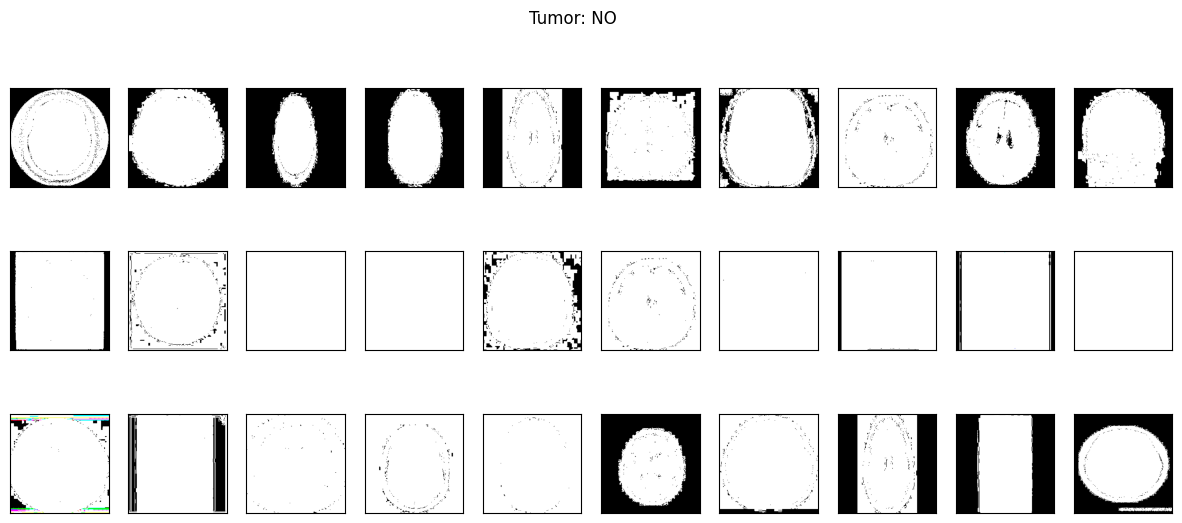

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [17.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [4.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [10.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB d

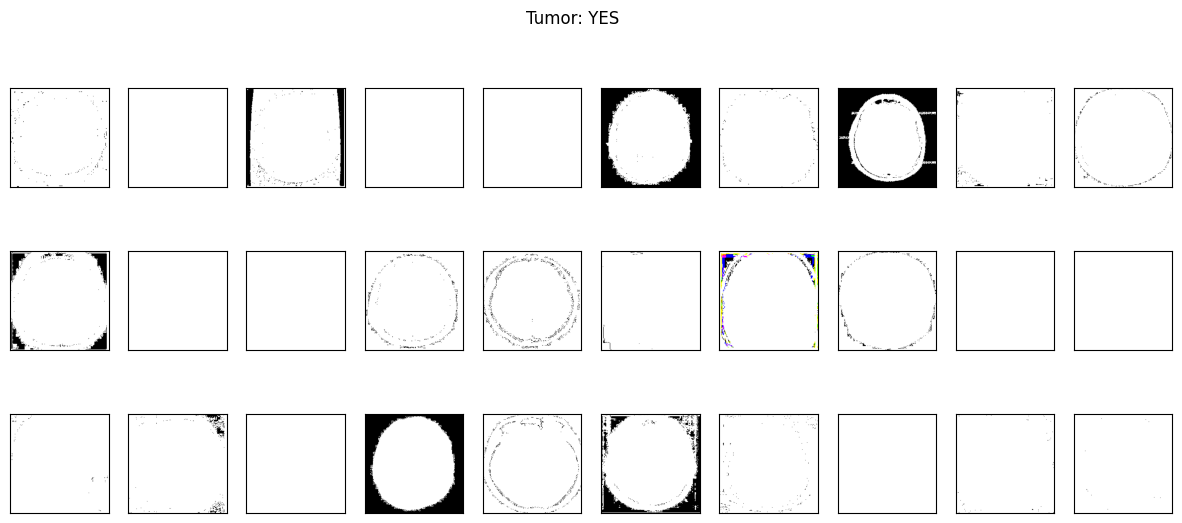

In [10]:
plot_samples(X_train, y_train, labels, 30)

As you can see, images have different `width` and `height` and diffent size of "black corners". Since the image size for VGG-16 imput layer is `(224,224)` some wide images may look weird after resizing. Histogram of ratio distributions (`ratio = width/height`):

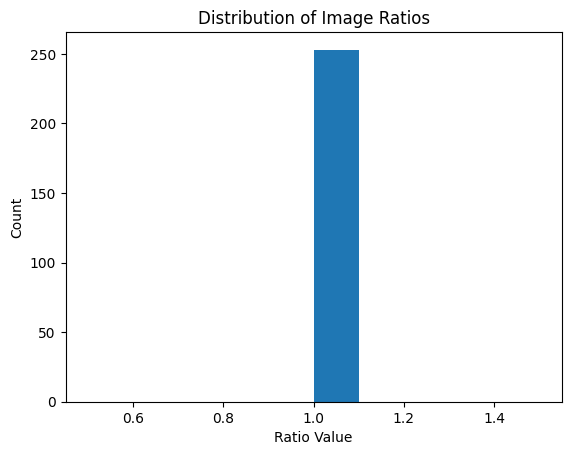

In [11]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

The first step of "normalization" would be to crop the brain out of the images. I used technique which was perfectly described in [pyimagesearch](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/) blog and I highly suggest to looks deeper into it.

In [12]:
def crop_imgs(set_name):
    cropped_list = []

    for img in set_name:

        # Ensure image is uint8
        img_uint = img.astype(np.uint8)

        # Convert to grayscale
        gray = cv2.cvtColor(img_uint, cv2.COLOR_RGB2GRAY)

        # Convert to uint8 to avoid errors in findContours
        gray = gray.astype(np.uint8)

        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # Threshold
        ret, thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)
        thresh = thresh.astype(np.uint8)

        # Remove noise
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # Find contours
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)

        if len(cnts) == 0:
            # no contours found → skip or keep original
            cropped_list.append(img_uint)
            continue

        c = max(cnts, key=cv2.contourArea)

        # Extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # Crop safely
        ADD = 0
        y1 = max(extTop[1] - ADD, 0)
        y2 = min(extBot[1] + ADD, img_uint.shape[0])
        x1 = max(extLeft[0] - ADD, 0)
        x2 = min(extRight[0] + ADD, img_uint.shape[1])

        new_img = img_uint[y1:y2, x1:x2].copy()

        # Resize back to original CNN size
        new_img = cv2.resize(new_img, (IMG_SIZE[1], IMG_SIZE[0]))

        cropped_list.append(new_img)

    return np.array(cropped_list)


Let's look at example what this function will do with MRI scans:

In [13]:
img = cv2.imread('brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

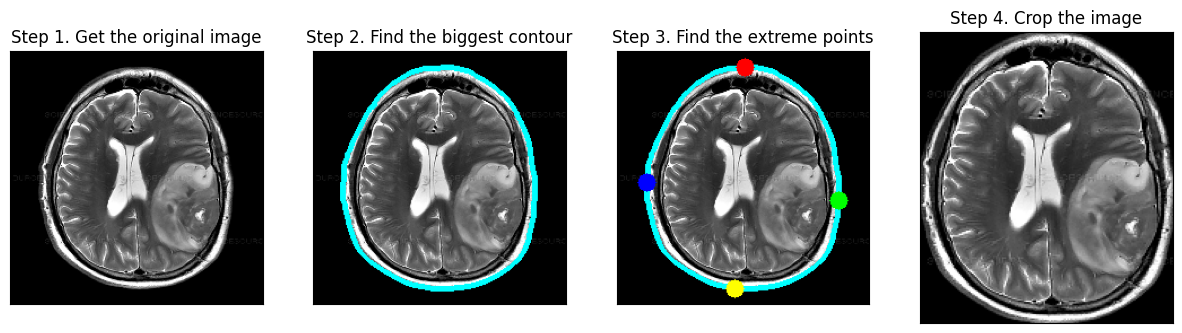

In [14]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [15]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

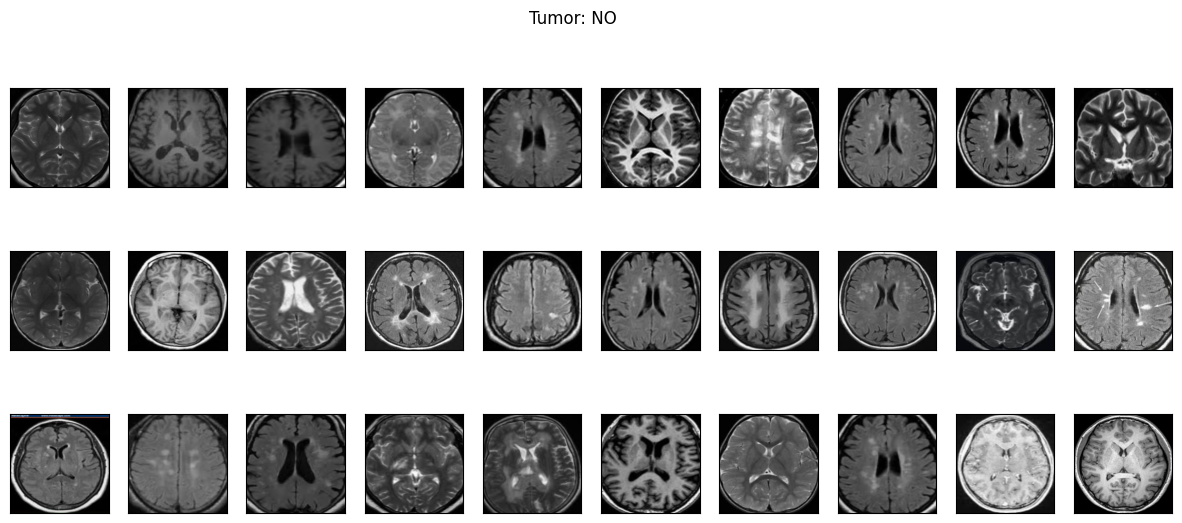

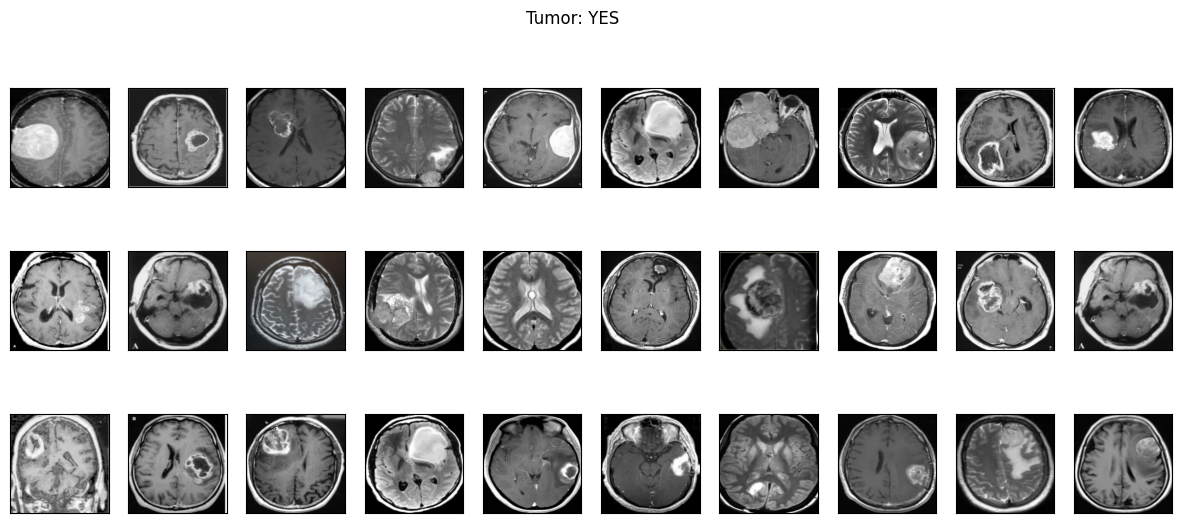

In [16]:
plot_samples(X_train_crop, y_train, labels, 30)

In [17]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [18]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

The syntax of the command is incorrect.


The next step would be resizing images to `(224,224)` and applying preprocessing needed for VGG-16 model input.

In [19]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [20]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [21]:
# plot_samples(X_train_prep, y_train, labels, 30)

# <a id='cnn'>4. CNN Model</a>

I was using [Transfer Learning](https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e) with VGG-16 architecture and weights as a base model.

## <a id='aug'>4.1. Data Augmentation</a>

Since I had small data set I used the technique called [Data Augmentation](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) which helps to "increase" the size of training set.

### <a id='demo'>4.1.1. Demo</a>

That's the example from one image how does augmentation look like.

In [22]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [23]:
os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

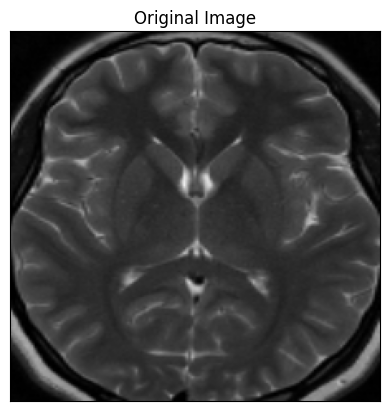

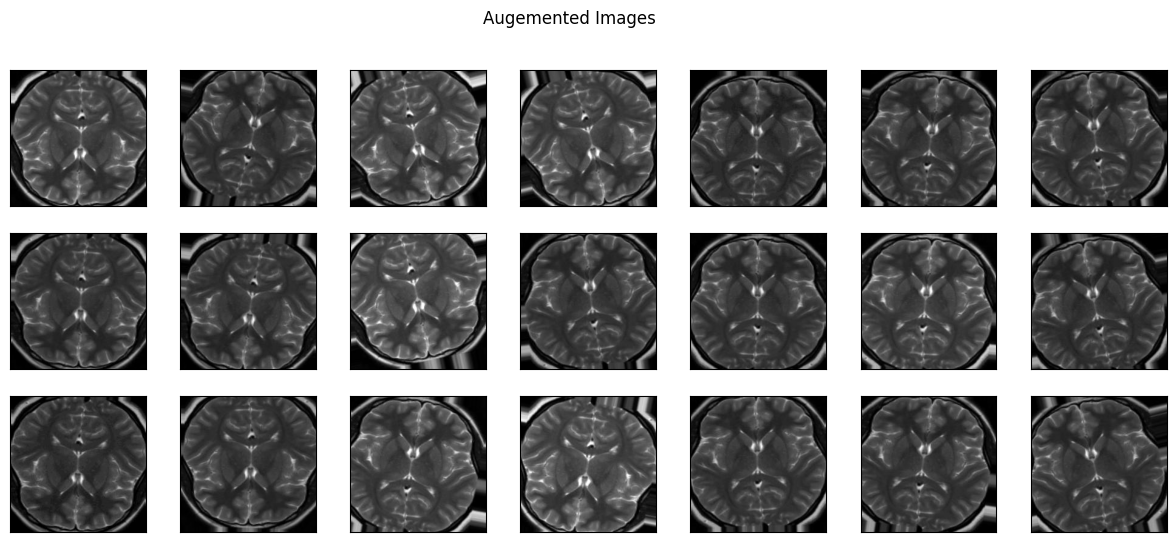

In [24]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [25]:
!rm -rf preview/

'rm' is not recognized as an internal or external command,
operable program or batch file.


### <a id='apply'>4.1.2. Apply</a>

In [26]:
def save_cropped_dataset(X, y, labels, out_dir):
    out_dir = out_dir.rstrip("/") + "/"
    
    # Create base output directory
    os.makedirs(out_dir, exist_ok=True)

    # Create class folders
    for cls_id, cls_name in labels.items():
        os.makedirs(os.path.join(out_dir, cls_name), exist_ok=True)

    # Save each cropped image
    for i, (img, label) in enumerate(zip(X, y)):
        cls_name = labels[label]
        save_path = os.path.join(out_dir, cls_name, f"img_{i}.jpg")
        cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

    print(f"Saved {len(X)} images to {out_dir}")

# Save cropped datasets
save_cropped_dataset(X_train_crop, y_train, labels, out_dir="TRAIN_CROP")
save_cropped_dataset(X_val_crop, y_val, labels, out_dir="VAL_CROP")
save_cropped_dataset(X_test_crop, y_test, labels, out_dir="TEST_CROP")

Saved 202 images to TRAIN_CROP/
Saved 24 images to VAL_CROP/
Saved 27 images to TEST_CROP/


In [27]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 202 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


## <a id='build'>4.2. Model Building</a>

In [28]:
base_model = VGG16(
    weights='imagenet',     # <-- FIX
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 341s 6us/step


In [31]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

# use 'learning_rate' argument (newer Keras/TensorFlow versions)
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,739,777 (56.23 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [34]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_accuracy',  # use the modern metric name
    mode='max',
    patience=6,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=[es]
)

c:\Users\Mohammed_Hany\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/30
  7/100 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - accuracy: 0.5957 - loss: 3.8039

c:\Users\Mohammed_Hany\envs\tf_env\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - accuracy: 0.5758 - loss: 4.0538 - val_accuracy: 0.6667 - val_loss: 3.3048
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - accuracy: 0.5703 - loss: 3.9061 - val_accuracy: 0.7500 - val_loss: 2.8487
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - accuracy: 0.6021 - loss: 3.7016 - val_accuracy: 0.7500 - val_loss: 2.2370
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - accuracy: 0.6587 - loss: 3.3939 - val_accuracy: 0.7917 - val_loss: 2.0261
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.6189 - loss: 3.6736 - val_accuracy: 0.7917 - val_loss: 1.5878
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.6457 - loss: 3.5314 - val_accuracy: 0.7917 - val_loss: 1.7679
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - accuracy: 0.6561 - loss: 3.0175 - val_accuracy: 0.7500 - val_loss: 2.2264
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.7383 - loss: 2.6007 - val

## <a id='perf'>4.3. Model Performance</a>

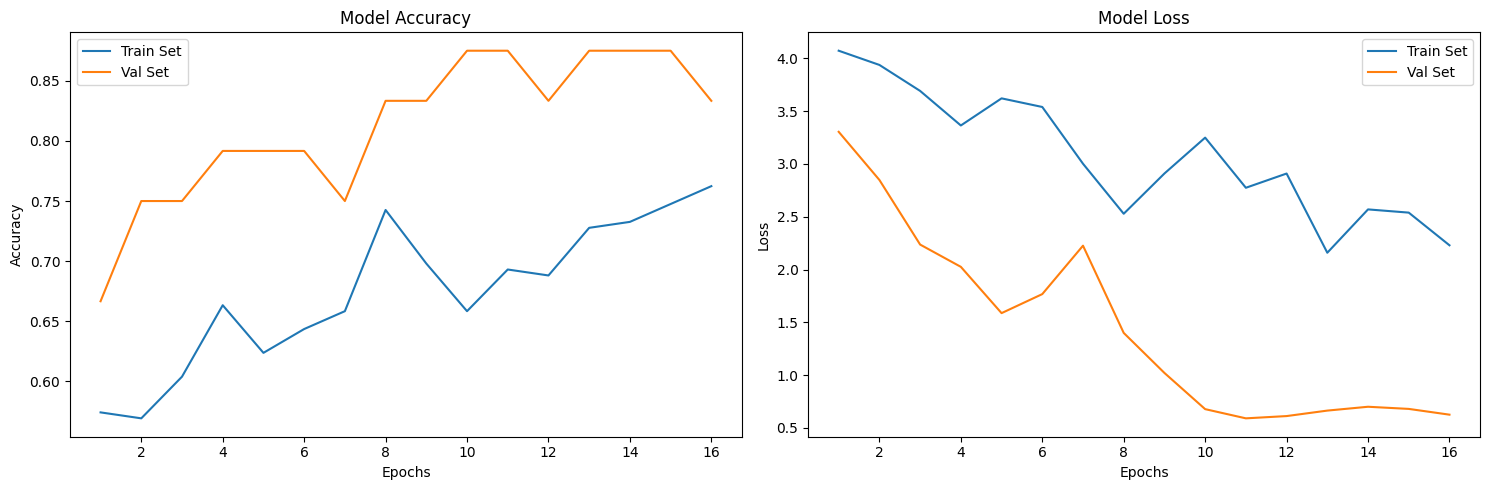

In [36]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Val Accuracy = 0.83


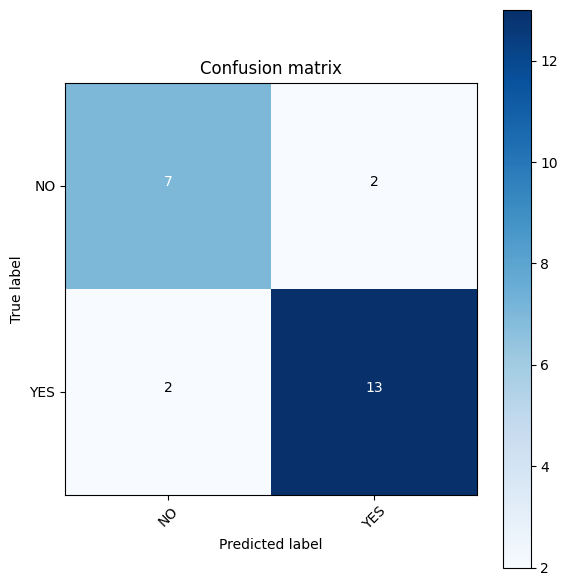

In [38]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions)

# helper: plot confusion matrix using matplotlib (uses already imported np and plt)
def plot_confusion_matrix(cm, class_names, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
	"""
	cm: confusion matrix (2D ndarray)
	class_names: list of class labels in order of indices (e.g. [ 'NO', 'YES' ])
	normalize: whether to normalize rows
	"""
	plt.figure(figsize=(6,6))
	if normalize:
		cm_display = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)
	else:
		cm_display = cm.copy()

	plt.imshow(cm_display, interpolation='nearest', cmap=cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(class_names))
	plt.xticks(tick_marks, class_names, rotation=45)
	plt.yticks(tick_marks, class_names)

	fmt = '.2f' if normalize else 'd'
	thresh = cm_display.max() / 2. if cm_display.size else 0.5
	for i in range(cm_display.shape[0]):
		for j in range(cm_display.shape[1]):
			plt.text(j, i, format(cm_display[i, j], fmt),
					 horizontalalignment="center",
					 color="white" if cm_display[i, j] > thresh else "black")

	plt.ylabel('True label')
	plt.xlabel('Predicted label')
	plt.tight_layout()
	plt.show()

# build class names from labels dict (labels maps int -> class_name)
class_names = [labels[k] for k in sorted(labels.keys())]
plot_confusion_matrix(confusion_mtx, class_names, normalize=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Test Accuracy = 0.78


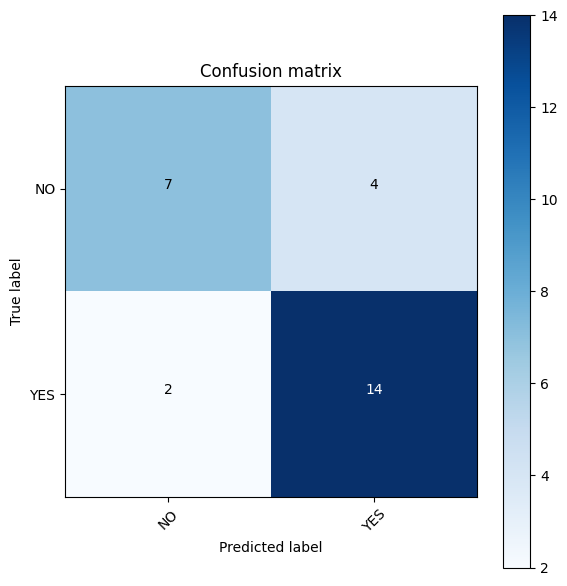

In [41]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions)

# build class names in the expected order and call the plotting helper correctly
class_names = [labels[k] for k in sorted(labels.keys())]
plot_confusion_matrix(confusion_mtx, class_names, normalize=False)

Now let's take a look at the images from the `test set` that were misclassified:

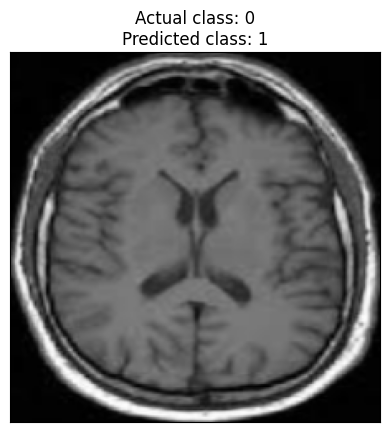

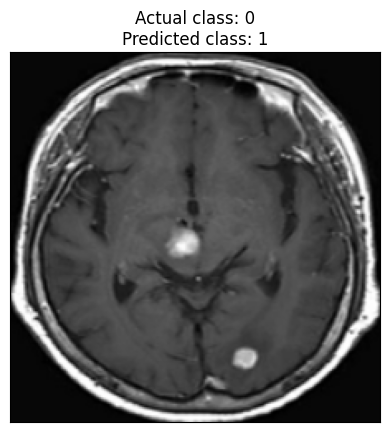

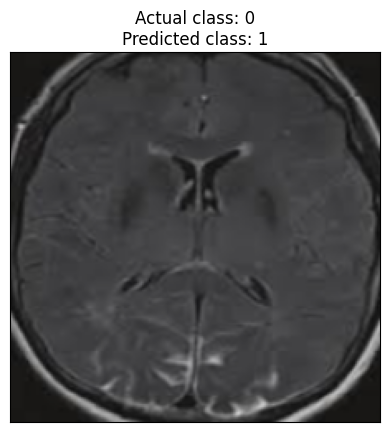

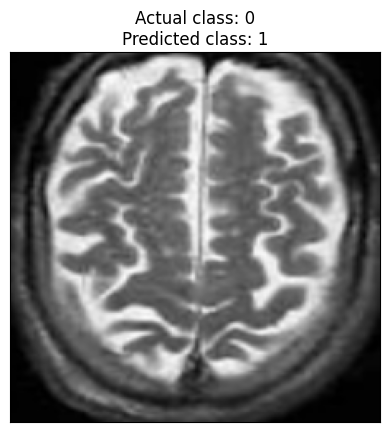

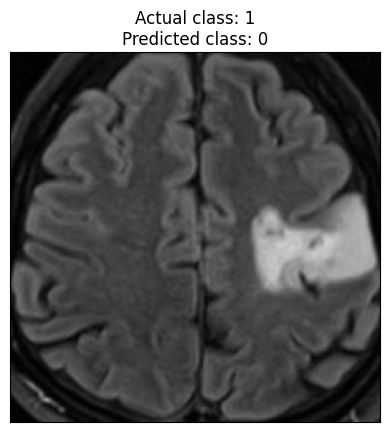

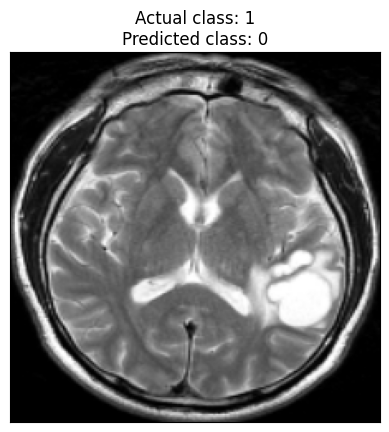

In [43]:
# Safely find misclassified indices even if lengths differ
preds_arr = np.array(predictions).astype(int).flatten()
y_test_arr = np.array(y_test).flatten()
n = min(len(preds_arr), len(y_test_arr), len(X_test_crop))

if len(preds_arr) != len(y_test_arr) or len(preds_arr) != len(X_test_crop):
    print(f"Warning: length mismatch (predictions={len(preds_arr)}, y_test={len(y_test_arr)}, X_test_crop={len(X_test_crop)}). Using first {n} samples.")

mis_idx = np.where(preds_arr[:n] != y_test_arr[:n])[0]

if mis_idx.size == 0:
    print('There are no misclassified images.')
else:
    for i in mis_idx:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        # use y_test (not y_val) as we are inspecting test set
        plt.title(f'Actual class: {y_test_arr[i]}\nPredicted class: {preds_arr[i]}')
        plt.show()

First scan looks a bit misleading - what is that light spot in the middle? 🤔 I can clearly see why model classified it as `Tumor`.

# <a id='concl'>5. Conclusions</a>

This project was a combination of CNN model classification problem (to predict wheter the subject has brain tumor or not) & Computer Vision problem (to automate the process of brain cropping from MRI scans). The final accuracy is much higher than 50% baseline (random guess). However, it could be increased by larger number of train images or through model hyperparameters tuning.

In [45]:
import joblib
import json

# ------------------------------------------------------
# 1. SAVE TRAINED MODEL
# ------------------------------------------------------
model.save("brain_tumor_vgg16_model.h5", save_format='h5')
print("Saved: brain_tumor_vgg16.h5")


# ------------------------------------------------------
# 2. SAVE CLASS INDICES (from ImageDataGenerator)
# ------------------------------------------------------
if 'train_generator' in globals():
    class_indices = train_generator.class_indices
    json.dump(class_indices, open("class_indices.json", "w"))
    print("Saved: class_indices.json")
else:
    print("WARNING: train_generator not found. Cannot save class indices.")


# ------------------------------------------------------
# 3. SAVE HUMAN-READABLE LABEL MAP
# ------------------------------------------------------
label_map = {v: k for k, v in class_indices.items()}
json.dump(label_map, open("label_map.json", "w"))
print("Saved: label_map.json")


# ------------------------------------------------------
# 4. SAVE PREPROCESSING INFO
# ------------------------------------------------------
preprocess_info = {
    "image_size": 224,
    "preprocessing": "vgg16_preprocess_input",
    "color_mode": "RGB"
}

json.dump(preprocess_info, open("preprocessing.json", "w"))
print("Saved: preprocessing.json")


print("\n=== ALL EXTRACTIONS COMPLETE ===")

Saved: brain_tumor_vgg16.h5
Saved: class_indices.json
Saved: label_map.json
Saved: preprocessing.json

=== ALL EXTRACTIONS COMPLETE ===
